# TP: Filtro de Kalman. Estimación de la trayectoria de un vehículo.

Se desea estimar la trayectoria de un vehículo, es decir la posición, velocidad y aceleración del mismo. Se cuenta con los datos reales de un vehículo, en los archivos .dat. Estos son los datos contra los cuales se comparará la estimacion que obtengan al aplicar el FK. 


In [3]:
# Importacion de librerias
import numpy as np 
import matplotlib.pyplot as plt

In [5]:
# Cargado de los datos reales de vehiculo
position = np.genfromtxt('posicion.dat')
velocity = np.genfromtxt('velocidad.dat')
acceleration = np.genfromtxt('aceleracion.dat')

print("Cargando informacion sobre la trayectoria")
print("Posicion de tamaño: {tam}".format(tam=position.shape))
print("Velocidad de tamaño: {tam}".format(tam=velocity.shape))
print("Aceleracion de tamaño: {tam}".format(tam=acceleration.shape))

Cargando informacion sobre la trayectoria
Posicion de tamaño: (351, 3)
Velocidad de tamaño: (351, 3)
Aceleracion de tamaño: (351, 3)


La información cargada tiene datos acerca de la posición, velocidad y aceleración de un vehículo que se mueve en el espacio. Se consideran tres ejes X, Y y Z, siendo X la primer columna del arreglo, Y la segunda y Z la tercera. El tiempo de muestreo de todas las medidas es de 1 segundo. Se tienen 351 muestras en cada uno de los ejes. A continuación se grafican cada una de las posiciones, velocidades y aceleraciones de cada uno de los ejes.

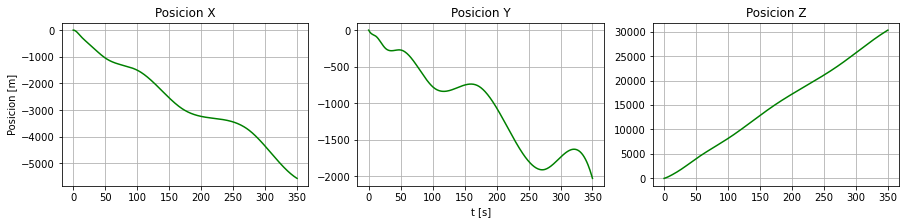

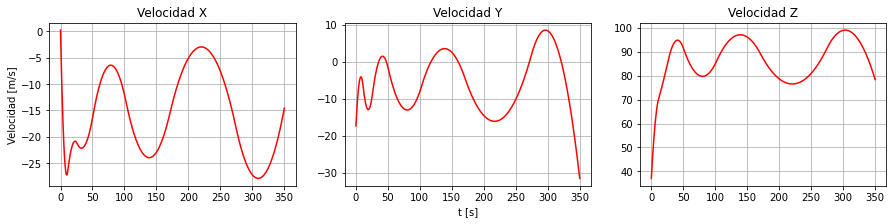

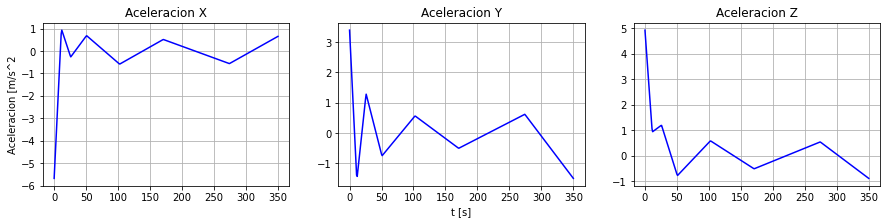

In [3]:
# Se grafican los valores reales medidos
# Se obtiene el valor de tiempos a partir de los datos reales
t = np.arange(0, position.shape[0])

# Posicion
figp, (posx, posy, posz) = plt.subplots(1, 3, figsize=(15, 3))
posx.plot(t, position[:,0], color="green")
posy.plot(t, position[:,1], color="green")
posz.plot(t, position[:,2], color="green")
# Titulos de las figuras
posx.set_title("Posicion X")
posy.set_title("Posicion Y")
posz.set_title("Posicion Z")
# Etiquetas en abcisas y oredenadas
posy.set_xlabel('t [s]')
posx.set_ylabel('Posicion [m]')
# Grid
posx.grid()
posy.grid()
posz.grid()

# Velocidad
figv, (velx, vely, velz) = plt.subplots(1, 3, figsize=(15, 3))
velx.plot(t, velocity[:,0], color="red")
vely.plot(t, velocity[:,1], color="red")
velz.plot(t, velocity[:,2], color="red")
# Titulos de las figuras
velx.set_title("Velocidad X")
vely.set_title("Velocidad Y")
velz.set_title("Velocidad Z")
# Etiquetas en abcisas y oredenadas
vely.set_xlabel('t [s]')
velx.set_ylabel('Velocidad [m/s]')
# Grid
velx.grid()
vely.grid()
velz.grid()

# Aceleracion
figa, (accelx, accely, accelz) = plt.subplots(1, 3, figsize=(15, 3))
accelx.plot(t, acceleration[:,0], color="blue")
accely.plot(t, acceleration[:,1], color="blue")
accelz.plot(t, acceleration[:,2], color="blue")
# Titulos de las figuras
accelx.set_title("Aceleracion X")
accely.set_title("Aceleracion Y")
accelz.set_title("Aceleracion Z")
# Etiquetas en abcisas y oredenadas
accely.set_xlabel('t [s]')
accelx.set_ylabel('Aceleracion [m/s^2')
# Grid
accelx.grid()
accely.grid()
accelz.grid()


Puede observarse en las figuras que la velocidad es la derivada de la posición, y la aceleración es la derivada de la velocidad. Esto se cumple para cada uno de los ejes X, Y y Z. Por lo que se puede suponer que los valores reales medidos son confiables para su utilización.

Para estimar las medidas de interés en función de los valores de las variables de medición disponibles se utiliza un filtro de kalman. Primero deben definirse las condiciones iniciales del sistema. Al inicializar el filtro de Kalman, en general, no se conoce exactamente cuál es la posición, velocidad y aceleración del vehículo, sino que se tiene una aproximación con cierto error. Se suponen condiciones iniciales $x_0$ de dimensiones $9x1$. Este vector contiene infomación de las posiciones iniciales en X, Y y Z en las primeras tres componentes, las velocidades iniciales X, Y y Z, en las segundas tres y lo mismo para la aceleración en las últimas tres componentes. Se supone que $x_0$ está descorrelacionado del proceso de ruido.  

In [6]:
# Vector de condiciones iniciales
x_0 = np.array([10.7533, 36.677, -45.1769, 1.1009, -17.0, 35.7418, -5.7247, 3.4268, 5.2774]).T

Dado que los valores iniciales no se conocen con exactitud y solo se realiza una estimación de los valores iniciales, se definen la matriz de errores iniciales $P_{0/0}$. Se define una matriz diagonal de dimensiones $9x9$ con los errores estimados para cada una de las posiciones, velocidades y aceleraciones. Se considera que los errores inciales son los mismos para las posiciones en cada uno de los ejes (100), lo mismo para todas las velocidades (1) y todas las aceleraciones (0,01).

In [7]:
# Covarianza del error inicial
diag = [100, 100, 100, 1, 1, 1, 0.01, 0.01, 0.01]
P_0 = np.zeros((9, 9))
np.fill_diagonal(P_0, diag)

Se considera la matriz de correlación del ruido $Q=0,3 . I_{9x9}$

In [8]:
Q = 0.3 * np.identity(9)

Se definen el modelo de estado del sistema a partir de la serie de Taylor. Se calculan las matrices A, B y C. Se supone un ruido aditivo y se considera a la matriz B como una matriz identidad. Dado que en un principio solo se tiene infomación sobre la posición, la matriz C tiene la forma $(I\; 0\; 0)$.

In [9]:
# Se definen las matrices del modelo
# h es igual a 1 dado que el tiempo de muestreo el igual a 1 s.
h = 1

# Se calculan las componentes de la matriz A
I = np.identity(3)
H = h * np.identity(3)
Z = np.zeros((3, 3))
H2 = h ** 2 / 2 * np.identity(3)
col1 = np.concatenate(((I, Z, Z)))
col2 = np.concatenate(((H, I, Z)))
col3 = np.concatenate(((H2, H, I)))

# Matrices del modelo
A = np.concatenate((col1, col2, col3), axis=1)
B = np.identity(9)
C = np.concatenate((I, Z, Z), axis=1)

## (1) Se mide la posición afectada por un ruido blanco gaussiano de 10 m de desvio estandar.  

Se define la matriz de autocorrelación de ruido del sistema y las condiciones iniciales. Se itera sobre los datos, en este caso solo se tiene información de la posición del vehículo. La medición tiene un ruido con media y varianza conocida. Se estiman las variables de estado del sistema en función de los valores medidos.  

In [10]:
# Define la matriz de autocorrelacion del ruido de estimación
# Se tiene una desviación estandar de 10 y una varianza de 100
sigma = 10
R = 10 ** 2 * np.identity(3)

# Se define una lista para almacenar las x_posteriori. 
# Se agrega como primer componente las condiciones iniciales estimadas 
x_posteriori_list = [x_0]
x_priori_list = [x_0]

# Se define una lista para almacenar las P_posteriori. 
# Se agrega como primer componente los errores iniciales estimados.
P_posteriori_list = [P_0]
P_priori_list = [P_0]

# Se define una lista para almacenar la diferencia entre el medido y el estimado
d_y_k = []
y_priori_list = [position[0]]

# Innovations
e_list = []


# Se itera sobre los datos para obtener las estimaciones
for i in range(position.shape[0] - 1):
    # Se obtiene la estimación de x_k dado k-1
    x_priori = A.dot(x_posteriori_list[-1])
    # Se obtiene el error prediccion del instante k dada k-1
    P_priori = A.dot(P_posteriori_list[-1]).dot(A.T) + B.dot(Q).dot(B.T)
    # Se define la ganancia de Kalman 
    # Esta pondera la infomacion nueva que da la nueva innovación
    K = P_priori.dot(C.T).dot(np.linalg.inv(R + C.dot(P_priori).dot(C.T)))
    # Se obtiene la posicion medida junto con la el ruido de medicion
    y_k = position[i] + np.random.normal(0, 10)
    # Se obtiene la nueva estimacion de x_k dado k
    x_posteriori = x_priori + K.dot(y_k - C.dot(x_priori))
    # Se calcula el nuevo error de prediccion del instante k dado k-1
    P_posteriori = (np.identity(9) - K.dot(C)).dot(P_priori)
    # Se agregan los valores a la lista para utilizarse en la proxima estimacion
    e_list.append(y_k - C.dot(x_priori))
    x_priori_list.append(x_priori)
    P_priori_list.append(P_priori)
    x_posteriori_list.append(x_posteriori)
    P_posteriori_list.append(P_posteriori)
    d_y_k.append(y_k - C.dot(x_priori))
    y_priori_list.append(C.dot(x_priori))
    

Una vez obtenidos los valores se grafican los errores entre los valores medidos y los valores estimados. 
A continuación se definen las funciones para realizar los gráficos.

In [11]:
# Se obtienen los graficos con los errores
def plot_errors(x_list): 
    t = np.arange(0, position.shape[0])
    for x in x_list:
        # Posicion
        figp, (posx, posy, posz) = plt.subplots(1, 3, figsize=(15, 3))
        posx.plot(t, (np.array(x)[:,0] - position[:,0]), color="green")
        posy.plot(t, (np.array(x)[:,1] - position[:,1]), color="green")
        posz.plot(t, (np.array(x)[:,2] - position[:,2]), color="green")
        # Titulos de las figuras
        posx.set_title("Error posicion X")
        posy.set_title("Error posicion Y")
        posz.set_title("Error posicion Z")
        # Etiquetas en abcisas y oredenadas
        posy.set_xlabel('t [s]')
        posx.set_ylabel('Delta posicion [m]')
        # Grid
        posx.grid()
        posy.grid()
        posz.grid()

        # Velocidad
        figv, (velx, vely, velz) = plt.subplots(1, 3, figsize=(15, 3))
        velx.plot(t, (np.array(x)[:,3] - velocity[:,0]), color="red")
        vely.plot(t, (np.array(x)[:,4] - velocity[:,1]), color="red")
        velz.plot(t, (np.array(x)[:,5] - velocity[:,2]), color="red")
        # Titulos de las figuras
        velx.set_title("Error velocidad X")
        vely.set_title("Error velocidad Y")
        velz.set_title("Error velocidad Z")
        # Etiquetas en abcisas y oredenadas
        vely.set_xlabel('t [s]')
        velx.set_ylabel('Velocidad [m/s]')
        # Grid
        velx.grid()
        vely.grid()
        velz.grid()

        # Aceleracion
        figa, (accelx, accely, accelz) = plt.subplots(1, 3, figsize=(15, 3))
        accelx.plot(t, (np.array(x)[:,6] - acceleration[:,0]), color="blue")
        accely.plot(t, (np.array(x)[:,7] - acceleration[:,1]), color="blue")
        accelz.plot(t, (np.array(x)[:,8] - acceleration[:,2]), color="blue")
        # Titulos de las figuras
        accelx.set_title("Error aceleracion X")
        accely.set_title("Error aceleracion Y")
        accelz.set_title("Error aceleracion Z")
        # Etiquetas en abcisas y oredenadas
        accely.set_xlabel('t [s]')
        accelx.set_ylabel('Error de aceleracion [m/s^2')
        # Grid
        accelx.grid()
        accely.grid()
        accelz.grid()

In [12]:
# Se obtienen los graficos con los errores
def plot_traj(x, x_priori): 
    t = np.arange(0, position.shape[0])
    # Posicion
    figp, (posx, posy, posz) = plt.subplots(1, 3, figsize=(20, 3))
    posx.plot(t, np.array(x)[:,0], color="green", label="Estimado posteriori")
    posx.plot(t, np.array(x_priori)[:,0], color="blue", label="Estimado priori")
    posx.plot(t, position[:,0], color="red", label="Real")
    posy.plot(t, np.array(x)[:,1], color="green", label="Estimado posteriori")
    posy.plot(t, np.array(x_priori)[:,1], color="blue", label="Estimado priori")
    posy.plot(t, position[:,1], color="red", label="Real")
    posz.plot(t, np.array(x)[:,2], color="green", label="Estimado posteriori")
    posz.plot(t, np.array(x_priori)[:,2], color="blue", label="Estimado priori")
    posz.plot(t, position[:,2], color="red", label="Real")
    # Titulos de las figuras
    posx.set_title("Posicion X")
    posy.set_title("Posicion Y")
    posz.set_title("Posicion Z")
    # Etiquetas en abcisas y oredenadas
    posy.set_xlabel('t [s]')
    posx.set_ylabel('Delta posicion [m]')
    # Labels 
    posx.legend(loc="upper right")
    posy.legend(loc="upper right")
    posz.legend(loc="upper right")
    # Grid
    posx.grid()
    posy.grid()
    posz.grid()

    # Velocidad
    figv, (velx, vely, velz) = plt.subplots(1, 3, figsize=(20, 3))
    velx.plot(t, np.array(x)[:,3], color="green", label="Estimado posteriori")
    velx.plot(t, np.array(x_priori)[:,3], color="blue", label="Estimado priori")
    velx.plot(t, velocity[:,0], color="red", label="Real")
    vely.plot(t, np.array(x)[:,4], color="green", label="Estimado posteriori")
    vely.plot(t, np.array(x_priori)[:,4], color="blue", label="Estimado priori")
    vely.plot(t, velocity[:,1], color="red", label="Real")
    velz.plot(t, np.array(x)[:,5], color="green", label="Estimado posteriori")
    velz.plot(t, np.array(x_priori)[:,5], color="blue", label="Estimado priori")
    velz.plot(t, velocity[:,2], color="red", label="Real")
    # Titulos de las figuras
    velx.set_title("Velocidad X")
    vely.set_title("Velocidad Y")
    velz.set_title("Velocidad Z")
    # Etiquetas en abcisas y oredenadas
    vely.set_xlabel('t [s]')
    velx.set_ylabel('Velocidad [m/s]')
    # Grid
    velx.grid()
    vely.grid()
    velz.grid()
    # Labels 
    velx.legend(loc="upper right")
    vely.legend(loc="upper right")
    velz.legend(loc="upper right")

    # Aceleracion
    figa, (accelx, accely, accelz) = plt.subplots(1, 3, figsize=(20, 3))
    accelx.plot(t, np.array(x)[:,6], color="green", label="Estimado posteriori")
    accelx.plot(t, np.array(x_priori)[:,6], color="blue", label="Estimado priori")
    accelx.plot(t, acceleration[:,0], color="red", label="Real")
    accely.plot(t, np.array(x)[:,7], color="green", label="Estimado posteriori")
    accely.plot(t, np.array(x_priori)[:,7], color="blue", label="Estimado priori")
    accely.plot(t, acceleration[:,1], color="red", label="Real")
    accelz.plot(t, np.array(x)[:,8], color="green", label="Estimado posteriori")
    accelz.plot(t, np.array(x_priori)[:,8], color="blue", label="Estimado priori")
    accelz.plot(t, acceleration[:,2], color="red")
    # Titulos de las figuras
    accelx.set_title("Aceleracion X")
    accely.set_title("Aceleracion Y")
    accelz.set_title("Aceleracion Z")
    # Etiquetas en abcisas y oredenadas
    accely.set_xlabel('t [s]')
    accelx.set_ylabel('Aceleracion [m/s^2')
    # Grid
    accelx.grid()
    accely.grid()
    accelz.grid()
    # Labels 
    accelx.legend(loc="upper right")
    accely.legend(loc="upper right")
    accelz.legend(loc="upper right")

In [13]:
# Se obtienen los graficos con los errores
def plot_y_errors(y, y_priori): 
    t = np.arange(0, position.shape[0])
    y_priori = np.array(y_priori)
    # Posicion
    figp, (posx, posy, posz) = plt.subplots(1, 3, figsize=(20, 3))
    posx.plot(t, y[:,0], color="blue", label="A priori")
    posx.plot(t, y_priori[:,0], color="red", label="Medido")
    posy.plot(t, y[:,1], color="blue", label="A priori")
    posy.plot(t, y_priori[:,1], color="red", label="Medido")
    posz.plot(t, y[:,2], color="blue", label="A priori")
    posz.plot(t, y_priori[:,2], color="red", label="Medido")
    # Titulos de las figuras
    posx.set_title("Posicion en x")
    posy.set_title("Posicion en y")
    posz.set_title("Posicion en z")
    # Etiquetas en abcisas y oredenadas
    posy.set_xlabel('t [s]')
    posx.set_ylabel('Delta posicion [m]')
    # Grid
    posx.grid()
    posy.grid()
    posz.grid()

    posx.legend()
    posy.legend()
    posz.legend()

    posx.set_xlim(200, 250)
    posy.set_xlim(200, 250)
    posz.set_xlim(200, 250)

    if y.shape[1] > 3:
        # Velocidad
        figv, (velx, vely, velz) = plt.subplots(1, 3, figsize=(20, 3))
        velx.plot(t, y[:,3], color="red", label="Medido")
        velx.plot(t, y_priori[:,3], color="blue", label="A priori")
        vely.plot(t, y[:,4], color="red", label="Medido")
        vely.plot(t, y_priori[:,4], color="blue", label="A priori")
        velz.plot(t, y[:,5], color="red", label="Medido")
        velz.plot(t, y_priori[:,5], color="blue", label="A priori")
        # Titulos de las figuras
        velx.set_title("Velocidad en x")
        vely.set_title("Velocidad en y")
        velz.set_title("Velocidad en z")
        # Etiquetas en abcisas y oredenadas
        vely.set_xlabel('t [s]')
        velx.set_ylabel('Velocidad [m/s]')
        # Grid
        velx.grid()
        vely.grid()
        velz.grid()

        velx.set_xlim(200, 250)
        vely.set_xlim(200, 250)
        velz.set_xlim(200, 250)


        velx.legend()
        vely.legend()
        velz.legend()


In [14]:
# Graficar error de predicción
def plot_pk(pk, pk_priori):
    t = np.arange(0, position.shape[0])
    #traces = np.array([np.trace(p) for p in pk])
    pk = np.array(pk)
    pk_priori = np.array(pk_priori)
    traces = np.trace(pk, axis1=1, axis2=2)
    traces_priori = np.trace(pk_priori, axis1=1, axis2=2)

    plt.plot(t, traces, color="red", label="Posteriori")
    plt.plot(t, traces_priori, color="blue", label="Priori")
    plt.xlabel("t [s]")
    plt.ylabel("Traza de P")
    plt.legend()
    plt.grid()
    
    

Se grafican los valores reales y estimados tanto a priori como a posteriori, puede verse que los valores de en las figuras siguientes. Se muestra que los valores estimados tanto de posición, velocidad y aceleración siguen los valores reales con un cierto error. Los valores estimados se ven afectados por el ruido de medición, los errores relativos son mayores en el caso de la aceleración, esto se debe a que dado que no se solo infomación sobre la posición, la estimación de la velocidad es más ruidosa y por lo tanto la estimación de la aceleración es más ruidosa aún.

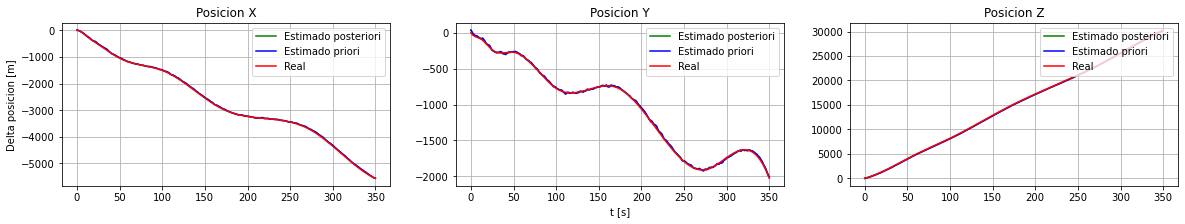

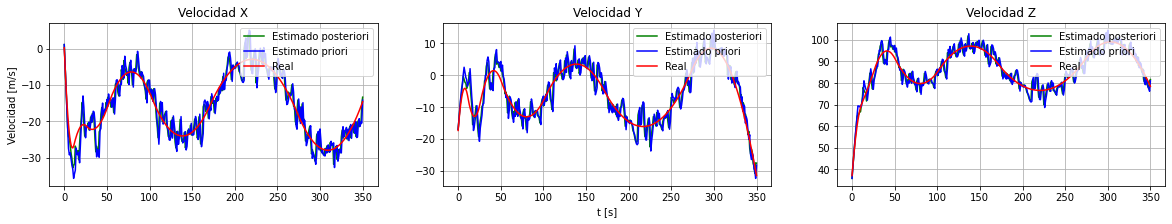

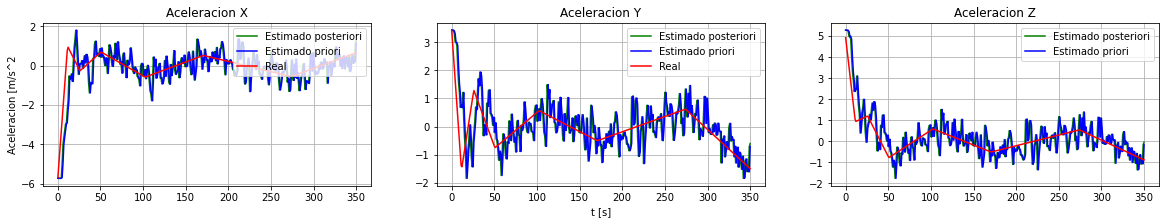

In [75]:
# Graficar trayectorias reales vs estimadas
plot_traj(x_posteriori_list, x_priori_list)

Se grafican los errores absolutos entre el valor real y el valor estimado. Esto da una idea de máximas diferencias que se pueden obtener en la estimación de cada una de las variables de estado del modelo. Puede apreciarse en las imágenes que los errores de posición se encuentran entre los $\pm 60 m$, los errrres de valocidad entre los $\pm 5 m/s$ y los errores de aceleración entre los $\pm 1 m/s^2$ aproximadamente. 

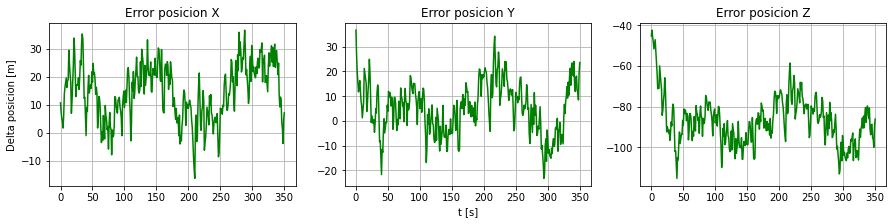

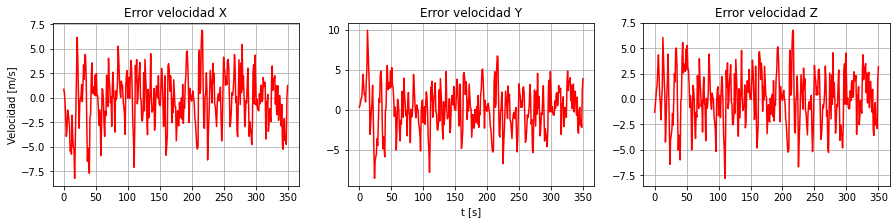

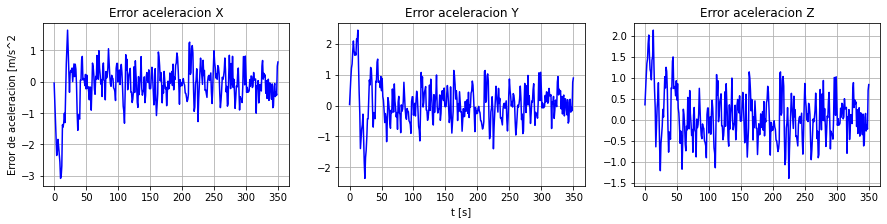

In [79]:
# Graficar errores
plot_errors([x_posteriori_list])

Se grafica las diferencias entre los valores reales $y_k$ y el estimado $y_{k|k-1}$. Ambos valores son muy similares, se utiliza un zoom entre las valores correspondientes a los tiempos $100s$  y $250s$ para ver las diferencias. Se observa que el filtro es efectivo para eliminar los ruidos de las mediciones.  

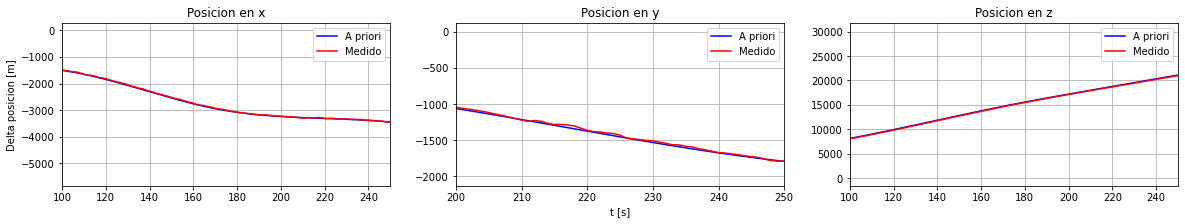

In [86]:
# Se grafica y_k contra el y_k estimado dado y_k-1
plot_y_errors(position, y_priori_list)

A continuación se grafica a la traza de la matriz de predicción a priori y a posteriori. Estas comienzan con un valor y luego van convergiendo a un valor constante.  Se observa que la traza de las matrices de errores a predicción $P_{k|k}$ es menor a la de $P_{k|k-1}$, esto se debe a que se tiene más información acerca de la trayectiria del vehículo.

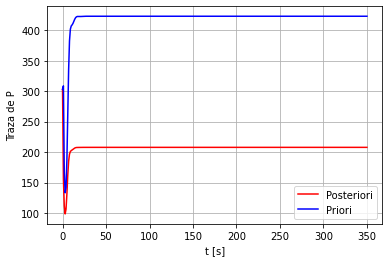

In [16]:
# Graficar traza de la matriz de prediccion P_posteriori
plot_pk(P_posteriori_list, P_priori_list)

## (2) Se mide la posición afectada por un ruido blanco uniforme de 10 de desvio estandar.

Se realiza el mismo procedimiento pero utilizado esta vez ruido blanco con una distribución uniforme con una desviación estándar de 10.

In [24]:
# Se realiza el mismo procedimiento que el realizado anteriormente
# Sin embargo en este caso el ruido es uniforme
sigma = 10
# Se calculan los limites de la distribución
lim = (sigma ** 2 * 12) ** 0.5 / 2
R = sigma ** 2 * np.identity(3)

x_posteriori_list_u = [x_0]
x_priori_list_u = [x_0]
P_posteriori_list_u = [P_0]
P_priori_list_u = [P_0]
y_priori_list_u = [position[0]]

for i in range(position.shape[0] - 1):
    x_priori = A.dot(x_posteriori_list_u[-1])
    P_priori = A.dot(P_posteriori_list_u[-1]).dot(A.T) + B.dot(Q).dot(B.T)
    P_priori_list_u.append(P_priori)
    K = P_priori.dot(C.T).dot(np.linalg.inv(R + C.dot(P_priori).dot(C.T)))
    y_k = position[i] + np.random.uniform(-lim, lim)
    x_posteriori = x_priori + K.dot(y_k - C.dot(x_priori))
    P_posteriori = (np.identity(9) - K.dot(C)).dot(P_priori)
    x_posteriori_list_u.append(x_posteriori)
    P_posteriori_list_u.append(P_posteriori)
    x_priori_list_u.append(x_priori)
    y_priori_list_u.append(C.dot(x_priori))

17.320508075688775


Se grafican nuevamente las trayectorias estimadas, puede verse en este caso que las diferencias similares a los obtenidas en el caso de que el ruido tenga una distribución normal.

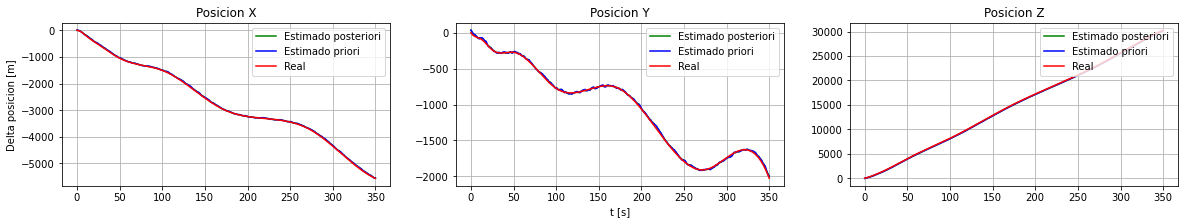

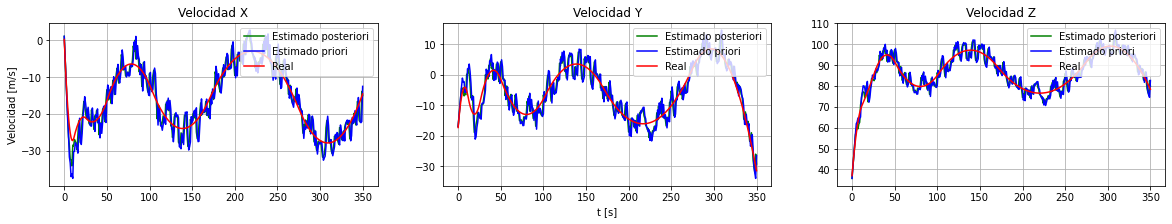

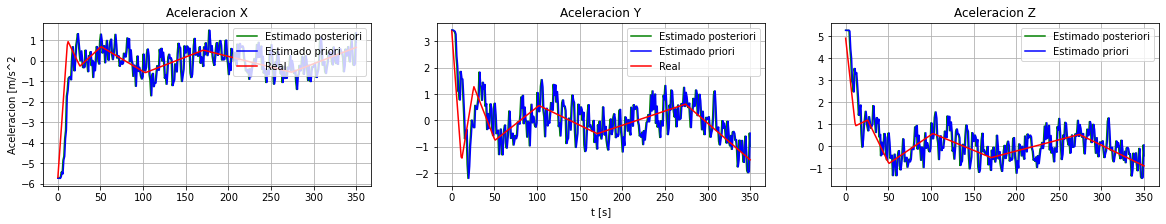

In [18]:
# Graficar trayectorias reales vs estimadas
plot_traj(x_posteriori_list_u, x_priori_list_u)

Los errores absolutos se muestran a continuación

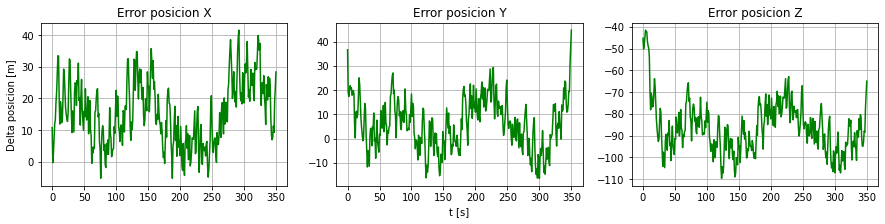

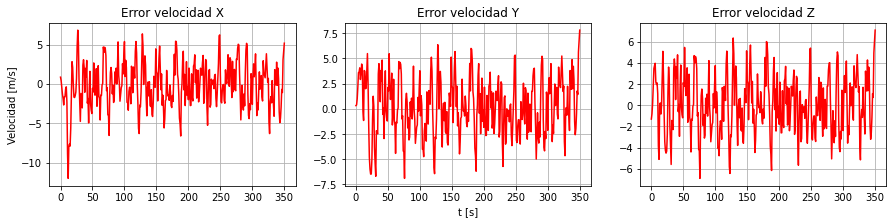

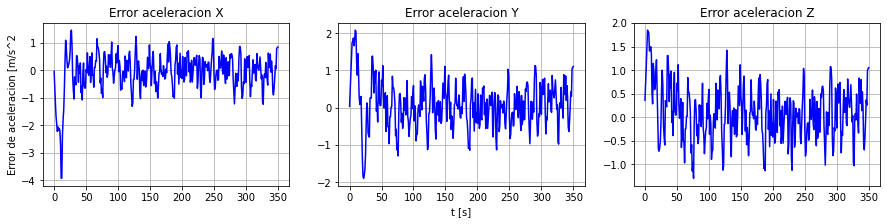

In [31]:
# Graficar errores
plot_errors([x_posteriori_list_u])

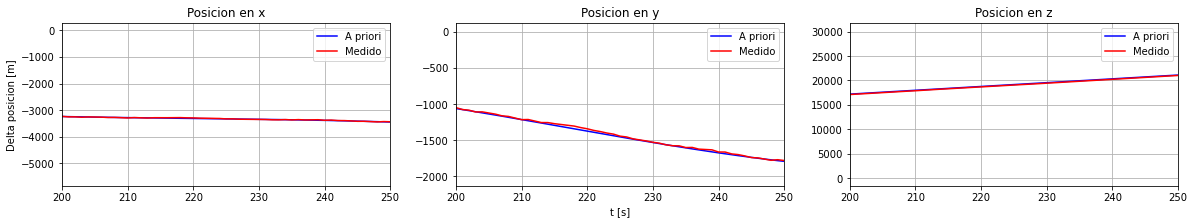

In [23]:
# Se grafica las
plot_y_errors(position, y_priori_list_u)

De forma simililar al caso anterior la predicción a posteriori es menor a la estimación a priori.

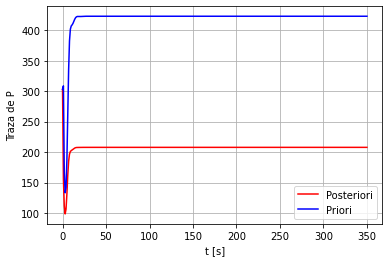

In [27]:
# Graficar traza de la matriz de prediccion P_posteriori
plot_pk(P_posteriori_list_u, P_priori_list_u)

## (3) Se mide la posición y la velocidad afectadas por ruido blanco gaussiando de 10 m y 0,2 m/s respectivamente.

En este caso además de tener información sobre la posición del sistema también se tiene información acerca de la velocidad con un cierto ruido de medición. Se calcula la nueva matriz $R$ y se realiza un procediemiento similar a los casos anteriores.

In [29]:
# Se define una nueva matriz R dado que se tienen mediciones de posicion y velocidad
sig_pos = 10
sig_vel = 0.2
diag = [sig_pos**2, sig_pos**2, sig_pos**2, sig_vel**2, sig_vel**2, sig_vel**2]
R = np.zeros((6,6))
np.fill_diagonal(R, diag)
# Se define una nueva matriz C por que se tienen mediciones de posicion y velocidad.
CV1 = np.concatenate((I, Z, Z), axis=1)
CV2 = np.concatenate((Z, I, Z), axis=1)
CV = np.concatenate((CV1, CV2))

# Se realiza el mismo procedimiento que en el caso anterior
x_posteriori_list_v = [x_0]
x_priori_list_v = [x_0]

P_posteriori_list_v = [P_0]
P_priori_list_v = [P_0]
y_priori_list_v = [np.concatenate((position[0], velocity[0]))]


for i in range(position.shape[0] - 1):
    x_priori = A.dot(x_posteriori_list_v[-1])
    P_priori = A.dot(P_posteriori_list_v[-1]).dot(A.T) + B.dot(Q).dot(B.T)
    P_priori_list_v.append(P_priori)
    K = P_priori.dot(CV.T).dot(np.linalg.inv(R + CV.dot(P_priori).dot(CV.T)))
    
    # En este caso se mide tanto posicion como velocidad
    y_x = position[i] + np.random.normal(0, 10)
    y_xp = velocity[i] + np.random.normal(0, 0.2)

    y_k = np.concatenate((y_x, y_xp))
    x_posteriori = x_priori + K.dot(y_k - CV.dot(x_priori))
    P_posteriori = (np.identity(9) - K.dot(CV)).dot(P_priori)

    x_posteriori_list_v.append(x_posteriori)
    P_posteriori_list_v.append(P_posteriori)
    x_priori_list_v.append(x_priori)
    y_priori_list_v.append(CV.dot(x_priori))


Al tener infomación sobre la velocidad las estimaciones son mucho más acertadas. 

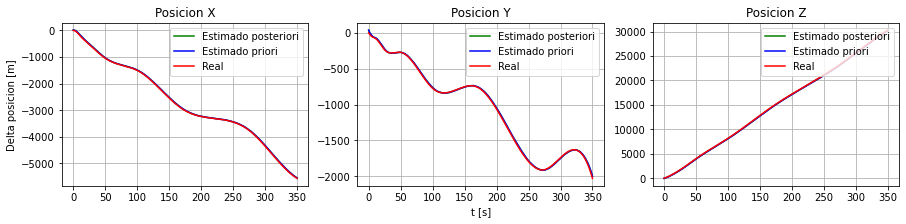

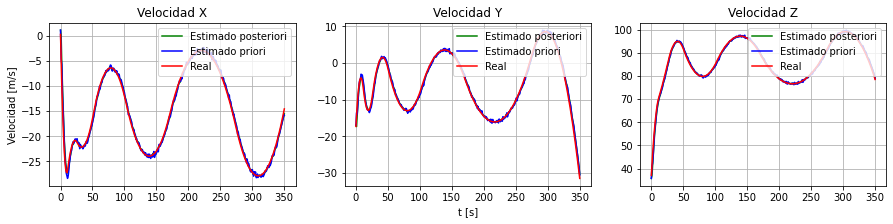

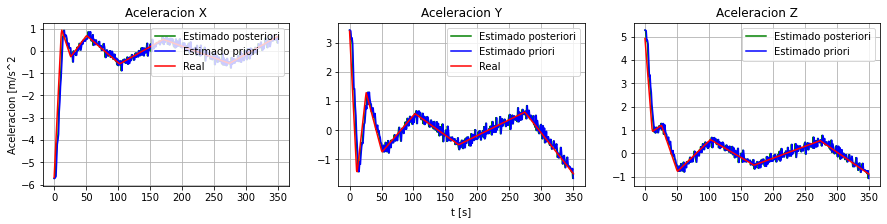

In [59]:
# Graficar trayectorias reales vs estimadas
plot_traj(x_posteriori_list_v, x_priori_list_v)

Puede observarse que al utilizar mediciones de posición y velocidad, se reducen los errores absolutos entre los valores reales y los valores estimados a priori y a posteriori. Dichos errores pueden observarse a continuación.

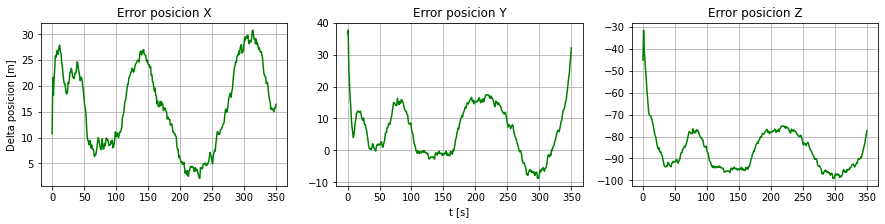

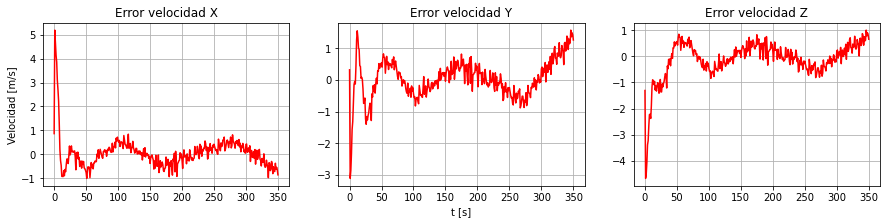

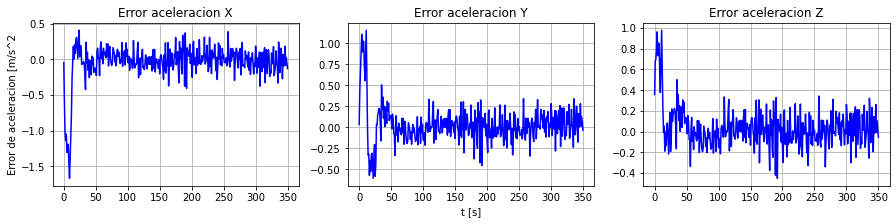

In [80]:
# Graficar errores
plot_errors([x_posteriori_list_v])

Se grafica el y real frente el y estimadp a priori.

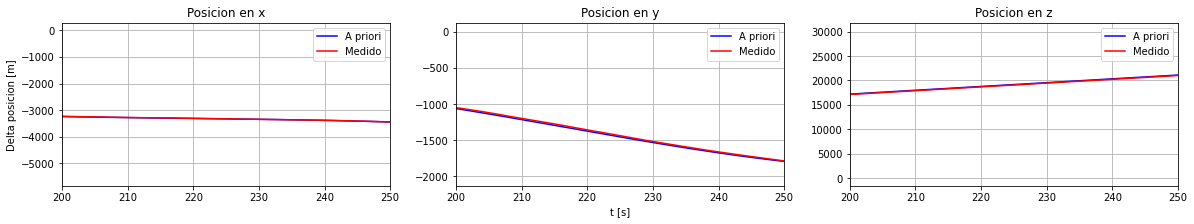

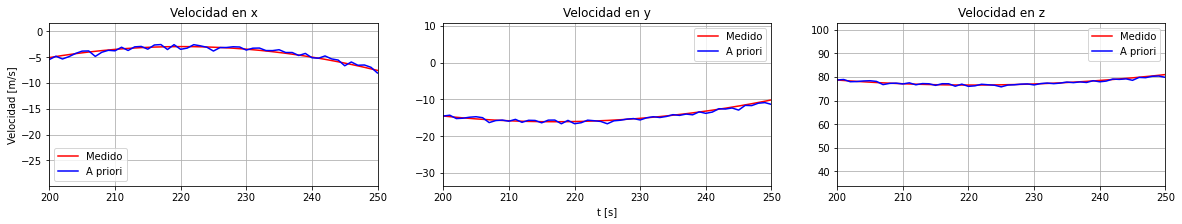

In [31]:
# Se grafica y_k contra el y_k estimado dado y_k-1
plot_y_errors(np.concatenate((position,velocity),axis=1), y_priori_list_v)

La trazas de las matrices de predicción se estabilizan en valores mucho menores.

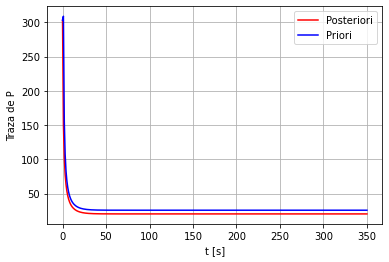

In [22]:
# Graficar traza de la matriz de prediccion P_posteriori
plot_pk(P_posteriori_list_v, P_priori_list_v)

Al tener información acerca de la velocidad del vehículo, puede verse que hay una reducción en el error de predicción. Dado que se tiene más información de la trayectoria del vehículo se reduce la incertidumbre en las estimaciones de las variables estado del sistema.